### Melbourn House Price Prediction

Data source: https://www.kaggle.com/datasets/anthonypino/melbourne-housing-market

Given data about the housing market in Melbourne, let's try to predict the price of a given property. 

We will use a multi-input Tensorflow neural network to make our predictions.

#### Importing libraries

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import r2_score

2024-07-17 16:12:28.865663: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-17 16:12:29.151315: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-17 16:12:29.151365: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-17 16:12:29.152336: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-17 16:12:29.314355: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-17 16:12:29.315258: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
data = pd.read_csv("MELBOURNE_HOUSE_PRICES_LESS.csv")
data

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63018,Roxburgh Park,3 Carr Pl,3,h,566000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63019,Roxburgh Park,9 Parker Ct,3,h,500000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63020,Roxburgh Park,5 Parkinson Wy,3,h,545000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63021,Thomastown,3/1 Travers St,3,u,NaN,PI,Barry,31/03/2018,3074,Northern Metropolitan,7955,15.3,Whittlesea City Council


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         63023 non-null  object 
 1   Address        63023 non-null  object 
 2   Rooms          63023 non-null  int64  
 3   Type           63023 non-null  object 
 4   Price          48433 non-null  float64
 5   Method         63023 non-null  object 
 6   SellerG        63023 non-null  object 
 7   Date           63023 non-null  object 
 8   Postcode       63023 non-null  int64  
 9   Regionname     63023 non-null  object 
 10  Propertycount  63023 non-null  int64  
 11  Distance       63023 non-null  float64
 12  CouncilArea    63023 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 6.3+ MB


#### Preprocessing

In [4]:
def onehot_encode(df, column_dict):
    df = df.copy()
    for column, prefix in column_dict.items():
        dummies = pd.get_dummies(df[column], prefix=prefix, dtype=int)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [5]:
def get_sequences(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)  # assignment based on frequency: most common word assigned number 1

    vocab_length = len(tokenizer.word_index) + 1
    
    print("Vocab Length: ", vocab_length)
    
    sequences = tokenizer.texts_to_sequences(texts)

    max_seq_length = np.max([len(sequence) for sequence in sequences])

    print('Max sequence length:', max_seq_length)

    sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post')
    
    return sequences

In [7]:
# get_sequences(X['Address'])

In [21]:
def preprocess_inputs(df):
    df = df.copy()

    # Drop rows with missing target values
    df = df.dropna(axis=0).reset_index(drop=True)

    # One-hot encode nominal features
    column_dict = {
        'Suburb': 'SU',
        'Type': 'TY',
        'Method': 'ME',
        'SellerG': 'SE',
        'Postcode': 'PO',
        'Regionname': 'RE',
        'CouncilArea': 'CO'
    }

    df = onehot_encode(df, column_dict)
    
    # Create date features
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

    df['Year'] = df['Date'].apply(lambda x: x.year)
    df['Month'] = df['Date'].apply(lambda x: x.month)
    df['Day'] = df['Date'].apply(lambda x: x.day)

    df = df.drop('Date', axis=1)

    # Get address sequences 
    addr_sequences = get_sequences(df['Address'])
    df = df.drop('Address', axis=1)
    
    # split df into X and y
    y = df['Price'].copy()
    X = df.drop('Price', axis=1).copy()

    # Scale X with a standard scaler
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    return X, addr_sequences, y

In [22]:
X, addr_sequences, y = preprocess_inputs(data)

Vocab Length:  10774
Max sequence length: 5


In [ ]:
# pd.to_datetime(X['Date']).apply(lambda x: x.year)

In [23]:
X

,Rooms,Propertycount,Distance,SU_Abbotsford,SU_Aberfeldie,SU_Airport West,SU_Albanvale,SU_Albert Park,SU_Albion,SU_Alphington,...,CO_Port Phillip City Council,CO_Stonnington City Council,CO_Whitehorse City Council,CO_Whittlesea City Council,CO_Wyndham City Council,CO_Yarra City Council,CO_Yarra Ranges Shire Council,Year,Month,Day
0,-0.075861,-0.795852,-1.285142,18.441189,-0.044332,-0.065356,-0.020325,-0.051476,-0.043147,-0.04193,...,-0.165485,-0.161289,-0.167385,-0.210713,-0.156232,5.974250,-0.060219,-0.053884,-0.960800,-1.766937
1,-0.075861,-0.795852,-1.285142,18.441189,-0.044332,-0.065356,-0.020325,-0.051476,-0.043147,-0.04193,...,-0.165485,-0.161289,-0.167385,-0.210713,-0.156232,5.974250,-0.060219,-0.053884,-0.960800,-1.766937
2,-0.075861,-0.795852,-1.285142,18.441189,-0.044332,-0.065356,-0.020325,-0.051476,-0.043147,-0.04193,...,-0.165485,-0.161289,-0.167385,-0.210713,-0.156232,5.974250,-0.060219,-0.053884,-0.960800,-1.766937
3,-0.075861,-1.351338,-0.689112,-0.054226,22.557062,-0.065356,-0.020325,-0.051476,-0.043147,-0.04193,...,-0.165485,-0.161289,-0.167385,-0.210713,-0.156232,-0.167385,-0.060219,-0.053884,-0.960800,-1.766937
4,-1.134401,-0.920365,-0.305003,-0.054226,-0.044332,15.300708,-0.020325,-0.051476,-0.043147,-0.04193,...,-0.165485,-0.161289,-0.167385,-0.210713,-0.156232,-0.167385,-0.060219,-0.053884,-0.960800,-1.766937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48428,-1.134401,2.128749,3.350649,-0.054226,-0.044332,-0.065356,-0.020325,-0.051476,-0.043147,-0.04193,...,-0.165485,-0.161289,-0.167385,-0.210713,-0.156232,-0.167385,-0.060219,1.259546,-1.281683,1.762982
48429,-0.075861,1.572814,-0.569906,-0.054226,-0.044332,-0.065356,-0.020325,-0.051476,-0.043147,-0.04193,...,-0.165485,-0.161289,-0.167385,-0.210713,-0.156232,-0.167385,-0.060219,1.259546,-1.281683,1.762982
48430,-0.075861,-0.388885,1.045999,-0.054226,-0.044332,-0.065356,-0.020325,-0.051476,-0.043147,-0.04193,...,-0.165485,-0.161289,-0.167385,-0.210713,-0.156232,-0.167385,-0.060219,1.259546,-1.281683,1.762982
48431,-0.075861,-0.388885,1.045999,-0.054226,-0.044332,-0.065356,-0.020325,-0.051476,-0.043147,-0.04193,...,-0.165485,-0.161289,-0.167385,-0.210713,-0.156232,-0.167385,-0.060219,1.259546,-1.281683,1.762982


In [25]:
y

0        1490000.0
1        1220000.0
2        1420000.0
3        1515000.0
4         670000.0
           ...    
48428     347700.0
48429     808000.0
48430     566000.0
48431     500000.0
48432     545000.0
Name: Price, Length: 48433, dtype: float64

#### Training

In [33]:
X_train, X_test, addr_train, addr_test, y_train, y_test = train_test_split(X, addr_sequences, y, train_size=0.7, random_state=123)

In [28]:
X_train.shape, addr_train.shape

((33903, 1069), (33903, 5))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 X_input (InputLayer)        [(None, 1069)]               0         []                            
                                                                                                  
 addr_input (InputLayer)     [(None, 5)]                  0         []                            
                                                                                                  
 X_dense1 (Dense)            (None, 512)                  547840    ['X_input[0][0]']             
                                                                                                  
 addr_embedding (Embedding)  (None, 5, 64)                689536    ['addr_input[0][0]']          
                                                                                              

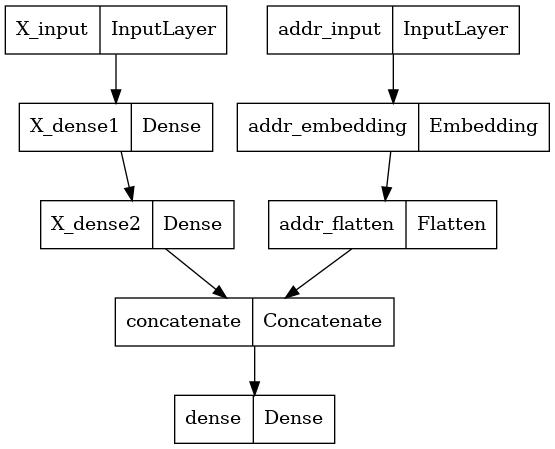

In [30]:
X_inputs = tf.keras.Input(shape=(X_train.shape[1],), name='X_input')
addr_inputs = tf.keras.Input(shape=(addr_train.shape[1], ), name='addr_input')

# X
X_dense1 = tf.keras.layers.Dense(512, activation='relu', name='X_dense1')(X_inputs)
X_dense2 = tf.keras.layers.Dense(512, activation='relu', name='X_dense2')(X_dense1)

# addr
addr_embedding = tf.keras.layers.Embedding(
    input_dim = 10774,
    output_dim = 64,
    input_length = addr_train.shape[1],
    name='addr_embedding'
)(addr_inputs)
addr_flatten = tf.keras.layers.Flatten(name='addr_flatten')(addr_embedding)

# concatenate
concat = tf.keras.layers.concatenate([X_dense2, addr_flatten], name='concatenate')

outputs = tf.keras.layers.Dense(1, activation='linear')(concat)

model = tf.keras.Model(inputs=[X_inputs, addr_inputs], outputs=outputs)

print(model.summary())
tf.keras.utils.plot_model(model)

In [31]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1),
    loss = 'mse'
)

history = model.fit(
    [X_train, addr_train],
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/50


2024-07-17 16:42:02.530710: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 231947344 exceeds 10% of free system memory.


847/848 [============================>.] - ETA: 0s - loss: 192395919360.0000

2024-07-17 16:42:25.198330: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 57991112 exceeds 10% of free system memory.


848/848 [==============================] - 23s 27ms/step - loss: 192367525888.0000 - val_loss: 133587648512.0000 - lr: 0.1000
Epoch 2/50
848/848 [==============================] - 19s 23ms/step - loss: 106732797952.0000 - val_loss: 119334969344.0000 - lr: 0.1000
Epoch 3/50
848/848 [==============================] - 19s 22ms/step - loss: 95512920064.0000 - val_loss: 120961900544.0000 - lr: 0.1000
Epoch 4/50
848/848 [==============================] - 19s 22ms/step - loss: 86558646272.0000 - val_loss: 125339525120.0000 - lr: 0.1000
Epoch 5/50
848/848 [==============================] - 19s 22ms/step - loss: 79476965376.0000 - val_loss: 122674495488.0000 - lr: 0.1000


#### Results

In [34]:
y_true = np.array(y_test)
y_pred = np.squeeze(model.predict([X_test, addr_test]))

  1/455 [..............................] - ETA: 1:02

2024-07-17 16:48:38.564858: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 124260560 exceeds 10% of free system memory.


455/455 [==============================] - 2s 4ms/step


In [35]:
model_r2 = r2_score(y_true, y_pred)

print('Model R^2 Score: {:.6f}'.format(model_r2))

Model R^2 Score: 0.714120
